Epoch 1:: 100%|██████████| 1875/1875 [00:19<00:00, 94.02it/s]


Epoch [1/5], Loss: 0.055198069848616915


Epoch 2:: 100%|██████████| 1875/1875 [00:21<00:00, 87.35it/s]


Epoch [2/5], Loss: 0.04073548290133476


Epoch 3:: 100%|██████████| 1875/1875 [00:20<00:00, 90.38it/s]


Epoch [3/5], Loss: 0.033068934878706935


Epoch 4:: 100%|██████████| 1875/1875 [00:19<00:00, 96.85it/s] 


Epoch [4/5], Loss: 0.029834651218851406


Epoch 5:: 100%|██████████| 1875/1875 [00:20<00:00, 92.28it/s]


Epoch [5/5], Loss: 0.027578112212816874


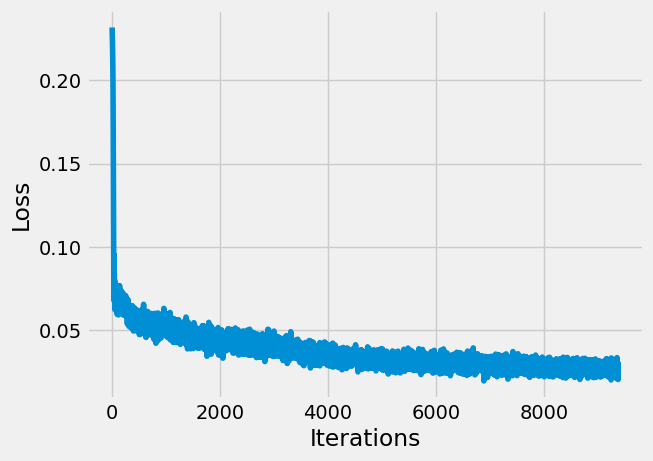

In [2]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Getting device to accelerate training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=tensor_transform
)

# DataLoader is used to load the dataset for training
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True
)

# Check the dataset length
len(train_dataset)

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Build an encoder with Linear layers followed by Relu
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        # Build a decoder with Linear layers followed by Relu
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Model Initialization
model = Autoencoder()
model.to(device)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-8
)

epochs = 5
outputs = []
losses = []
running_loss = 0.0

for epoch in range(epochs):
    for (image, _) in tqdm(train_loader, f"Epoch {epoch + 1}:"):

        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28 * 28)
        image = image.to(device)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        running_loss += loss.item()
        losses.append(loss.cpu().detach().numpy())

    print(
        f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader)}"
    )
    running_loss = 0.0

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting
plt.plot(losses)
plt.show()

# Download the MNIST Test Dataset
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=tensor_transform
)

# DataLoader is used to load the dataset for testing
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False
)
loader_iter = iter(test_loader)



torch.Size([1, 9])


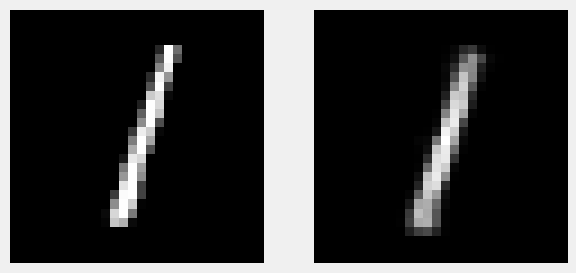

In [5]:

# Testing model
image, _ = next(loader_iter)
image = image.reshape(-1, 28*28)
image = image.to(device)

# Output of Autoencoder
bottleneck = model.encoder(image)
reconstructed = model.decoder(bottleneck)

image = image.reshape(-1, 28, 28)
reconstructed = reconstructed.reshape(-1, 28, 28)

print(bottleneck.shape)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image[0].cpu().detach().numpy(), cmap='gray')
axs[0].axis("off")
axs[1].imshow(reconstructed[0].cpu().detach().numpy(), cmap='gray')
axs[1].axis("off")
plt.show()